In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
from monty.serialization import dumpfn, loadfn

In [3]:
from doped.generation import DefectsGenerator
from shakenbreak.input import Distortions

In [4]:
from ase.filters import FrechetCellFilter
from ase.optimize import LBFGS
from pymatgen.io.ase import AseAtomsAdaptor#
from fairchem.core import pretrained_mlip, FAIRChemCalculator

auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
MODEL = "uma"

In [37]:
supercell_sizes = [10.1,10.2, 10.5, 10.6, 10.7]

In [7]:
uma_ff = pretrained_mlip.get_predict_unit("uma-m-1p1", device="cuda")
uma_calc = FAIRChemCalculator(uma_ff, task_name="omat")

MODELS = {
    'uma': uma_calc
}

In [8]:
def full_relax_structure(structure):
    atoms = structure.to_ase_atoms()
    atoms.calc = MODELS[MODEL]

    opt = LBFGS(FrechetCellFilter(atoms))
    opt.run(0.01, 1000)

    relaxed_structure = AseAtomsAdaptor.get_structure(atoms)
    energy = atoms.get_potential_energy()

    return relaxed_structure, energy, len(atoms) 
    

In [9]:
def relax_structure(structure): # takes in pymatgen structure
    atoms = structure.to_ase_atoms()
    atoms.calc = MODELS[MODEL]

    opt = LBFGS(atoms) 
    opt.run(0.01, 1000)

    relaxed_structure = AseAtomsAdaptor.get_structure(atoms)
    energy = atoms.get_potential_energy()

    return relaxed_structure, energy, len(atoms)

In [10]:
AlClO_primitive = loadfn(f'../data/{MODEL}/{MODEL}_relaxed_Al_prim.json')

In [11]:
def bulk_supercell_creation(structure, supercell_size):
    defect_gen = DefectsGenerator(structure, extrinsic="Cr", interstitial_gen_kwargs=False, supercell_gen_kwargs={'min_image_distance':supercell_size} ) # set large super cell 25 Angstroms 'supercell_gen_kwargs={'min_image_distance':15}valid_keys = []

    return defect_gen.bulk_supercell

In [46]:
AlClO_supercells = {} 
# AlClO_supercells = loadfn(f'../data/{MODEL}/{MODEL}_bulk_supercell_energy_experiment.json')

In [47]:
for size in supercell_sizes:
    if size == 10.1:
        if size not in AlClO_supercells.keys():
            supercell_structure = bulk_supercell_creation(AlClO_primitive_structure, size)
            fully_relaxed_structure, fully_relaxed_energy, full_relaxed_n_atoms = full_relax_structure(supercell_structure)
            relaxed_structure, relaxed_energy, relaxed_n_atoms = relax_structure(supercell_structure)
            multiplier = full_relaxed_n_atoms / n_primitive_atoms
            AlClO_supercells[size] = {
                'fully relaxed structure' : fully_relaxed_structure,
                'fully relaxed energy' : fully_relaxed_energy,
                'n atoms' : full_relaxed_n_atoms,
                'relaxed structure' : relaxed_structure,
                'relaxed energy' : relaxed_energy,
                'expected energy multiplier' : multiplier,
                'full energy per primitive' : fully_relaxed_energy / multiplier,
                'energy per primitive' : relaxed_energy / multiplier
            }

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:48,   2.08it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.125,0.125,0.125]  16c
v_Fe         [+1,0,-1,-2]       [0.500,0.500,0.500]  8b
v_O          [+2,+1,0,-1]       [0.359,0.359,0.359]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_Fe            [+1,0]              [0.500,0.500,0.500]  8b
Al_O             [+5,+4,+3,+2,+1,0]  [0.359,0.359,0.359]  32e
Fe_Al            [+1,0,-1,-2]        [0.125,0.125,0.125]  16c
Fe_O             [+5,+4,+3,+2,+1,0]  [0.359,0.359,0.359]  32e
O_Al             [0,-1,-2,-3,-4,-5]  [0.125,0.125,0.125]  16c
O_Fe             [0,-1,-2,-3,-4]     [0.500,0.500,0.500]  8b
Cr_Al            [+3,+2,+1,0,-1]     [0.125,0.125,0.125]  16c
Cr_Fe            [+4,+3,+2,+1,0]     [0.500,0.500,0.500]  8b
Cr_O             [+5,+4,+3,+2,+1,0]  [0.359,0.359,0.359]  32e

The number in t

In [17]:
dumpfn(AlClO_supercells, f'../data/{MODEL}/{MODEL}_bulk_supercell_energy_experiment.json') 

In [30]:
AlClO_supercells = loadfn(f'../data/{MODEL}/{MODEL}_bulk_supercell_energy_experiment.json')

In [31]:
import matplotlib.pyplot as plt

In [60]:
full_energies = []
for size in supercell_sizes:
    full_energies.append(AlClO_supercells[size]['full energy multiplied'])

In [61]:
energies = []
for size in supercell_sizes:
    energies.append(AlClO_supercells[size]['energy multiplied'])

[-35.19884084516134, -35.19883914974033, -35.19884453875712, -35.19885414362007]


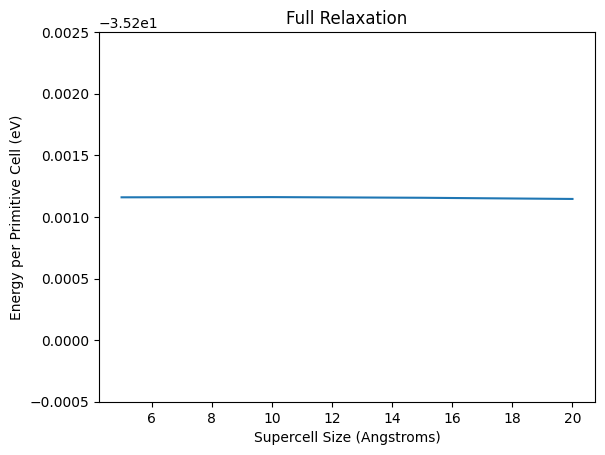

In [77]:
plt.plot(supercell_sizes, full_energies)
print(full_energies)
plt.ylim(-35.2005, -35.1975)
plt.ylabel('Energy per Primitive Cell (eV)')
plt.xlabel('Supercell Size (Angstroms)')
plt.savefig(F'../figures/{MODEL}/{MODEL}_full_relaxation_supercells_energy.png')
plt.title('Full Relaxation')
plt.show()

[-35.19883914974033, -35.19883914974033, -35.19884508371386, -35.19885414362007]


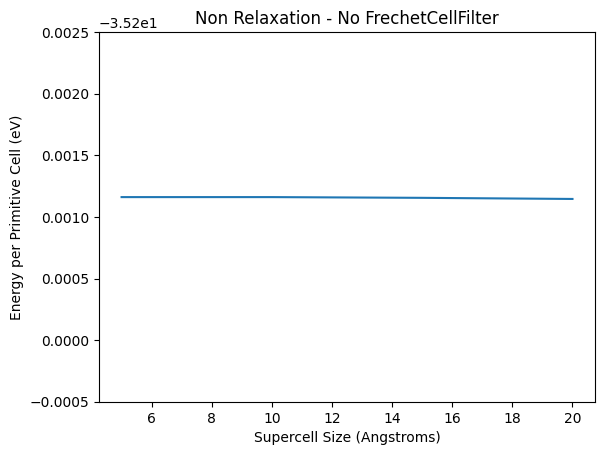

In [78]:
plt.plot(supercell_sizes, energies)
print(energies)
plt.ylabel('Energy per Primitive Cell (eV)')
plt.xlabel('Supercell Size (Angstroms)')
plt.title('Non Relaxation - No FrechetCellFilter')
plt.ylim(-35.2005, -35.1975)
plt.savefig(F'../figures/{MODEL}/{MODEL}_non_relaxation_supercells_energy.png')
plt.show()